Generate XRD composition "scans" by interpolating between different CoxNix phases. We put in exaggerated (i.e. unphysical) lattice parameter changes to test the peak shift invariance of embedding models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
CoNi = pd.read_json("../inputs/mp-1226076_xrd_Cu_CoNi.json", lines=True)
Co = pd.read_json("../inputs/mp-1183710_xrd_Cu_Co.json", lines=True)
Ni = pd.read_json("../inputs/mp-10257_xrd_Cu_Ni.json", lines=True)

In [173]:
%run xrdutils.py

In [110]:
condense?

In [221]:
X.shape

(800, 800)

In [225]:
import pdb

In [249]:
def from_json(df):
    patterns = np.array(df.pattern.iloc[0], dtype = object)
    intensities, angles = patterns[:, 0].astype(float), patterns[:, 2].astype(float)
    q = to_q(angles)
    return q, intensities

def df_to_pat(df):
    q, i = from_json(df)
    pat = mk_pattern(i, q, .01)
    return q, i, pat

def plt_pat(df, **kwargs):
    q, i, pat = df_to_pat(df)
    plt.plot(q_grid, pat, **kwargs)
    return q_grid, pat, i, q\

def agg(X, n_classes = 25):
    #assert n_classes * per_class == X.shape[0]
    CoNi_members = X.reshape(n_classes, X.shape[0] // n_classes, X.shape[1]).sum(axis = 1)
    CoNi_y = np.hstack([np.repeat(i, 1) for i in range(n_classes)])[None, :].T
    #pdb.set_trace()
    return CoNi_members, CoNi_y

def sample_transition(*pieces, n_classes = 24, per_class = 500):
    X = np.vstack(pieces)
    X, _ = agg(X, n_classes = n_classes)
    X_samples, y = mk_simdata(X, per_class, -.5, .5, q_grid, scale_type = 'shift')
    return X_samples, y

def group_patterns(*pieces, n_classes = 200, rmin = -.2, rmax = .2):
    """
    Instead of averaging the rows and doing data augmentation, just group them.
    """
    per_class = 600 // n_classes
    X = np.vstack(pieces)
    y = np.hstack([np.repeat(i, per_class) for i in range(n_classes)])[None, :].T
    X = np.vstack([condense(mutate_pattern(row, np.random.uniform(rmin, rmax), scale_type = 'shift', peak_height = True), 150) for row in X])
    return X, y

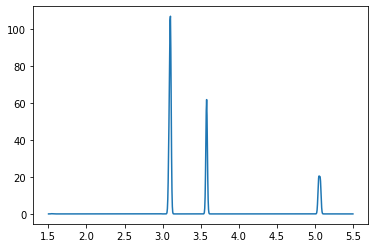

In [15]:
_, _, ib, qb = plt_pat(CoNi);

In [16]:
qb.shape

(31,)

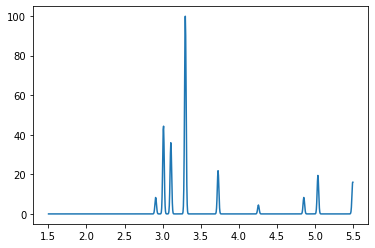

In [324]:
qqa, iia, ia, qa = plt_pat(Co);

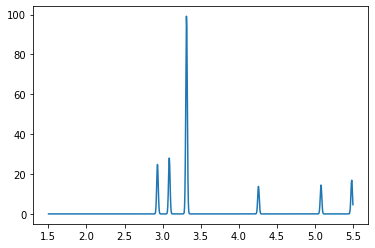

In [18]:
_, _, ic, qc = plt_pat(Ni);

In [21]:
%matplotlib inline

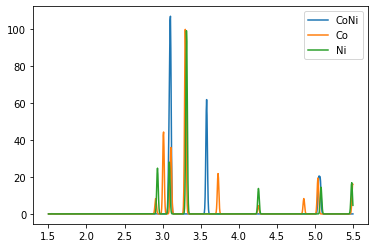

In [22]:
plt_pat(CoNi, label = 'CoNi');
plt_pat(Co, label = 'Co');
plt_pat(Ni, label = 'Ni');
plt.legend()

In [23]:
def transition(start_scale, end_scale, start_pair, end_pair, N, sigma = .01, scale_type = 'scale'):
    """
    pair -> [qs, intensities]
    
    scale_type == 'scale' changes peak positions multiplicatively (in q)
    scale_type == 'shift' shifts peak positions equally (which is not what a lattice parameter change does,
        but it's simpler than doing the q -> log(q) substitution and pretty much equivalent for model testing
        purposes)
        
    TODO
    Lorentz factor
    peak height variation
    """
    scales = np.linspace(start_scale, end_scale, N)
    res = []
    q0, i0 = start_pair
    q1, i1 = end_pair
    
    qq, ii = np.hstack((q0, q1)), np.hstack((i0, i1))
    span = np.abs(start_scale - end_scale)
    for i, s in enumerate(scales):
        if scale_type == 'scale':
            q, i = qq * s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
        elif scale_type == 'shift':
            q, i = qq + s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
        else:
            raise Exception 
        pat = mk_pattern(i, q, sigma)
        res.append(pat)
    return np.vstack(res)

In [24]:
qt, it = np.array([1, 2]), np.array([.5, .6])
qt2, it2 = np.array([2, 3]), np.array([.4, .2])

assert transition(1, 1.5, (qt, it), (qt2, it2), 2).shape == (2, q_grid.shape[0])

2D scan of 1D XRD patterns, henceforth known as "the dataset":

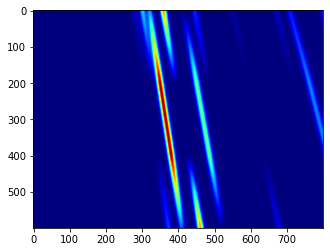

In [28]:
sigma = .03
Co_to_CoNi = transition(1, 1.05, (qa, ia), (qb, ib), 200, sigma)

CoNi_to_CoNi = transition(1.05, 1.1, (qb, ib), (qb, ib), 200, sigma)

CoNi_to_Ni = transition(1.1, 1.15, (qb, ib), (qc, ic), 200, sigma)

X = np.vstack((Co_to_CoNi, CoNi_to_CoNi, CoNi_to_Ni))
plt.imshow(X, cmap = 'jet')

## NMF decomposition

In [30]:
from sklearn.decomposition import NMF

In [31]:
def do_nmf(n = 10):
    model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000)
    W = model.fit_transform(X.T)
    H = model.components_
    return W, H, np.linalg.norm(np.dot(W, H) - X.T)

In [32]:
nn = np.arange(1, 41, dtype = int)

losses = np.array([do_nmf(n)[2] for n in nn])

/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/l

In [279]:
%matplotlib inline

Text(0, 0.5, 'L2 loss')

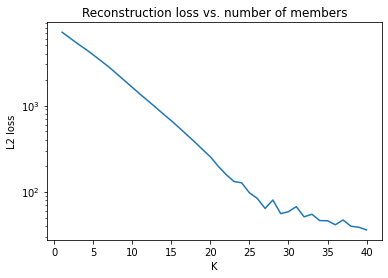

In [35]:
plt.plot(nn, losses)
plt.semilogy()
plt.title("Reconstruction loss vs. number of members")
plt.xlabel("K")
plt.ylabel("L2 loss")

In [33]:
K = 10
W, H, loss = do_nmf(K)
loss

1624.051581484437

Text(0.5, 1.0, 'Original and reconstructed (K = 10)')

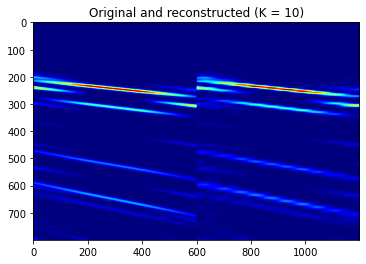

In [34]:
%matplotlib inline
plt.imshow(np.hstack((X.T, (np.dot(W, H)))), cmap = 'jet')
plt.title("Original and reconstructed (K = {})".format(K))

In [319]:
%matplotlib notebook

In [45]:
import tensorflow as tf
from xrdc import sims
from importlib import reload
from xrdc import utils

reload(utils)
reload(sims)

<module 'xrdc.sims' from '/Users/ollie/Documents/SLAC/xrd_clustering/notebooks/xrdc/sims.py'>

In [572]:
# from tensorflow.keras.datasets import mnist

# a, b = mnist.load_data()

In [39]:
# def to_img(y_cond, size, v_padding = 2):
#     normed = y_cond / y_cond.max()
#     y_indices = (v_padding - 1 + (size - 2 * v_padding) * normed).astype(int)
#     sig2d = np.zeros((size, size))
#     x_indices = np.arange(0, size, step = 1)
#     sig2d[x_indices, y_indices] = 1
#     return sig2d.T[::-1]

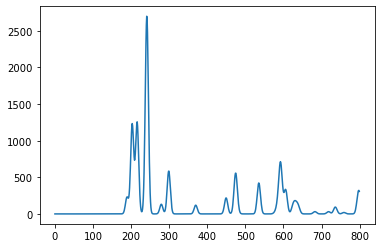

In [265]:
plt.plot(CoNi_members[0])

In [266]:
reload(utils)

<module 'xrdc.utils' from '/Users/ollie/Documents/SLAC/xrdsim/xrdc/utils.py'>

In [267]:
CoNi_members, CoNi_y = agg(X)

CoNi_x, CoNi_y = sims.mk_simdata(CoNi_members, 500, 20, scale_type = 'scale')

scale type: scale


In [268]:
CoNi_test_x, CoNi_test_y = np.repeat(CoNi_test_x, 7, axis = 0)[:10000, :], np.repeat(CoNi_test_y, 7, axis = 0)[:10000]

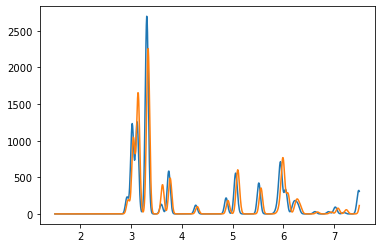

In [237]:
plt.plot(q_grid, CoNi_members[0])
plt.plot(q_grid, CoNi_members[1])

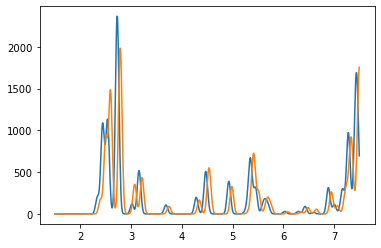

In [239]:
plt.plot(q_grid, CoNi_members_shift[0])
plt.plot(q_grid, CoNi_members_shift[1])

In [195]:
utils.write_train_test("data/CoNi_3/", CoNi_x, CoNi_y, CoNi_x, CoNi_y)

In [199]:
# Co_to_CoNi_shift = transition(-.6, -.2, (qa, ia), (qb, ib), 200, sigma, scale_type = 'shift')

# CoNi_to_CoNi_shift = transition(-.2, .2, (qb, ib), (qb, ib), 200, sigma, scale_type = 'shift')

# CoNi_to_Ni_shift = transition(.2, .6, (qb, ib), (qc, ic), 200, sigma, scale_type = 'shift')

More realistic dataset (lattice parameter changes only in multi phase region):

In [174]:
def gcluster(X, N = 6):
    aglom = AgglomerativeClustering(N, affinity='cosine', linkage = 'single').fit(X)
    ypred = aglom.labels_

    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    Xpca = pca.fit_transform(X)

    return Xpca, ypred

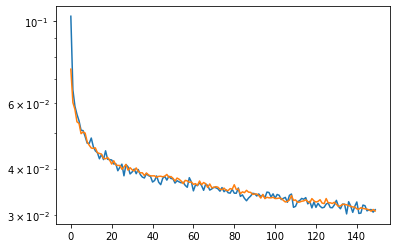

In [190]:
import matplotlib.pyplot as plt
plt.semilogy()
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

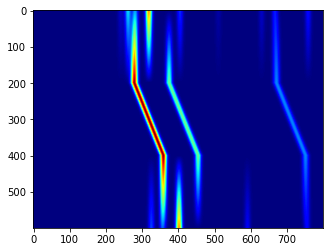

In [169]:
sigma = .03
shift_size = .2
Co_to_CoNi_shift = transition(-shift_size, -shift_size, (qa, ia), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_CoNi_shift = transition(-shift_size, shift_size, (qb, ib), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_Ni_shift = transition(shift_size, shift_size, (qb, ib), (qc, ic), 200, sigma, scale_type = 'shift')

X = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [229]:
q_grid.shape

(800,)

In [244]:
%pdb

Automatic pdb calling has been turned ON


In [250]:
CoNi_x_shift, CoNi_y_shift = sample_transition(Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 200, per_class = 5)

scale type: shift
q jitter: None


In [251]:
CoNi_y_shift.shape, CoNi_x_shift.shape

((1000, 1), (1000, 150))

In [232]:
%run xrdutils.py


<Figure size 432x288 with 0 Axes>

In [224]:
CoNi_x_shift.shape

(1000, 150)

In [104]:
(((CoNi_y_shift // 67).T)== 2).sum()

330

In [81]:
write_train_test("data/CoNi_shift_2/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift, CoNi_y_shift // 8)

In [192]:
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/CoNi_shift_2/train/ --test_path data/CoNi_shift_2/test/\
    --name CoNi_shift_2 \
    --n_classes 177 --epochs 200

  0%|          | 0/75000 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


  6%|▌         | 4256/75000 [00:51<14:08, 83.36it/s, epoch=11, train_loss=0.0492, val_loss=0.0483] 


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

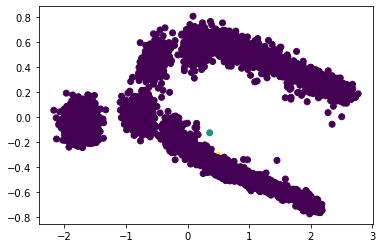

In [191]:
X = utils.get_embedding(net, original_test_loader)[0]

In [211]:
Xpca, ypred = gcluster(X, N = 3)

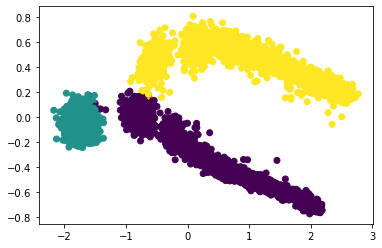

In [213]:
plt.scatter(*(Xpca.T), c = ypred)

In [220]:
CoNi_y_shift.shape

(1000, 1)

### Add a fourth transition from Ni to Co to complete the loop:

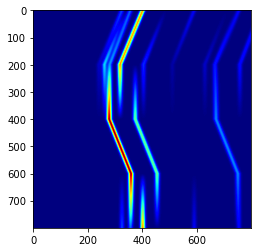

In [217]:
sigma = .03
Ni_to_Co = transition(shift_size, -shift_size, (qc, ic), (qa, ia), 200, sigma, scale_type = 'shift')

X = np.vstack((Ni_to_Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [ ]:
CoNi_x_shift, CoNi_y_shift = sample_transition(Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 200, per_class = 5)

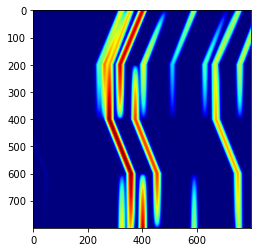

In [219]:
plt.imshow(np.log(1 + X), cmap = 'jet')

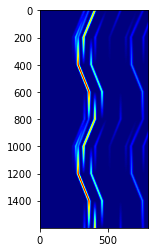

In [218]:
plt.imshow(np.vstack((X, X)), cmap = 'jet')

In [269]:
CoNi_x_shift_extended, CoNi_y_shift_extended = sample_transition(Ni_to_Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 40, per_class = 250)

scale type: shift
q jitter: None


In [284]:
write_train_test("data/CoNi_shift_extended/", CoNi_x_shift_extended, CoNi_y_shift_extended,
                 CoNi_x_shift_extended, CoNi_y_shift_extended // 10)

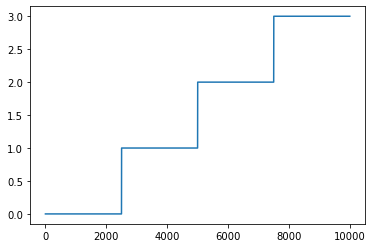

In [285]:
plt.plot(CoNi_y_shift_extended // 10)

In [286]:
prefix="CoNi_shift_extended"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 200 --epochs 150

  0%|          | 0/46950 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 46950/46950 [09:36<00:00, 81.42it/s, epoch=149, train_loss=0.026, val_loss=0.0255]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_extended-*


<Figure size 432x288 with 0 Axes>

In [301]:
from xrdc.utils.utils import utils as outils

<IPython.core.display.Javascript object>


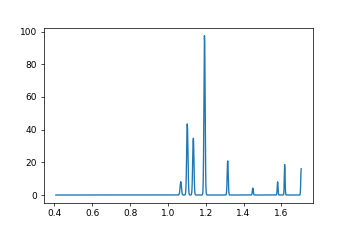

In [363]:
x = q_grid
y = iia

from scipy.interpolate import interp1d
def logtransform(x, y):
    logx = np.log(x)
    interp = interp1d(logx, y)

    logx_new = np.linspace(logx.min(), logx.max(), len(logx))
    return logx_new, interp(logx_new)

plt.plot(*logtransform(x, y))

In [353]:
%matplotlib notebook

In [364]:
xl1, il1 = logtransform(x, mutate_pattern(y, .95, x, peak_height=False))

In [365]:
xl2, il2 = logtransform(x, mutate_pattern(y, 1, x, peak_height=False))

<IPython.core.display.Javascript object>


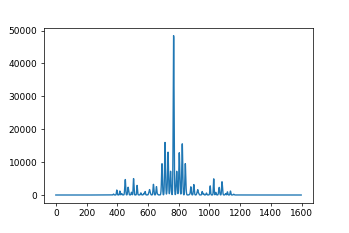

([<matplotlib.lines.Line2D at 0x7fc61267be50>],
 1.6572125458766052,
 1.704293560424763,
 -0.05129329438755058,
 0.048704497808439995)

In [392]:
plt.plot(np.correlate(il1, il2, mode = 'full')), xl1[770], xl1[799], np.log(.95), 30 * (xl1[1] - xl1[0])

In [ ]:
plt.plot()

In [362]:
plt.plot(*logtransform(x, mutate_pattern(y, .95, x, peak_height=False)))
plt.plot(*logtransform(x, mutate_pattern(y, 1., x, peak_height=False)))

<IPython.core.display.Javascript object>

In [293]:
X_emb, y = utils.get_embedding(net, original_test_loader)

In [291]:
Xpca, ypred = gcluster(X_emb, N = 4)

In [311]:
Xpca.T

(2, 10000)

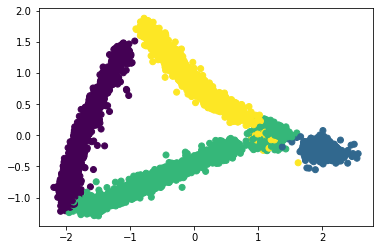

In [315]:
plt.scatter(*(Xpca.T), c = ypred)

In [306]:
plt.scatter?

### Co-Ni synthetic dataset clustering

* Augmented datset with 20 dummy classes
* 4-dimensional latent space
* GMM recovers clusters much better than K means due to non-spherical shape of the clusters
* 4 dimensional latent space better than 2 for identifying clusters

In [ ]:
plt.scatter(*(Xpca.T), c = ypred)

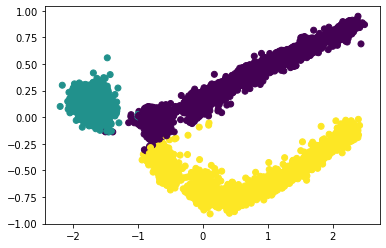

In [105]:
write_train_test("data/CoNi_shift_small/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift,\
                 (CoNi_y_shift // 67))

In [115]:
CoNi_x_shift_group, CoNi_y_shift_group = group_patterns(Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 200)

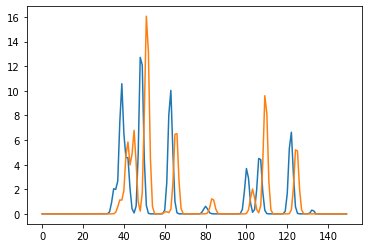

In [119]:
plt.plot(CoNi_x_shift_group[0])
plt.plot(CoNi_x_shift_group[2])

In [121]:
write_train_test("data/CoNi_shift_grouped/", CoNi_x_shift_group, CoNi_y_shift_group, CoNi_x_shift_group,\
                 (CoNi_y_shift_group // 67))

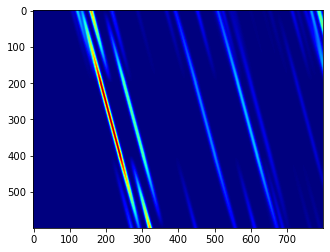

In [202]:
X_shift = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X_shift, cmap = 'jet')

In [212]:
CoNi_members_shift, CoNi_y_shift = agg(X_shift)

In [214]:
CoNi_x_shift, CoNi_y_shift = sims.mk_simdata(CoNi_members_shift, 500, 20, scale_type = 'shift')

utils.write_train_test("data/CoNi_shift/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift, CoNi_y_shift)

scale type: shift


In [241]:
assert np.where(np.isnan(CoNi_x) == True)

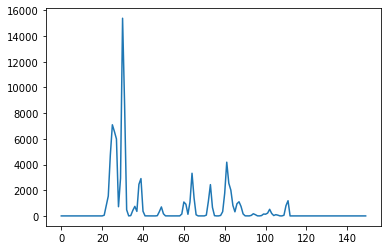

In [269]:
plt.plot(CoNi_x[15])

In [ ]:
def condense(arr, newsize):
    extra = newsize - (len(arr) % newsize)
    arr = np.hstack((arr, np.zeros(extra)))
    return arr.reshape(newsize, -1).sum(axis = 1)

def view_ds(arr):
    """
    2d heatmap of dataset, rows sorted by first moment in q
    """
    plt.imshow(arr[np.argsort(
    (arr * condense(q_grid, 150)).mean(axis = 1)
)].reshape(200, 50, 150).sum(axis = 1))